In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dont-overfit-ii/sample_submission.csv
/kaggle/input/dont-overfit-ii/train.csv
/kaggle/input/dont-overfit-ii/test.csv


In [3]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import StandardScaler


# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train =  pd.read_csv('/kaggle/input/dont-overfit-ii/train.csv')
df_test =  pd.read_csv('/kaggle/input/dont-overfit-ii/test.csv')

In [5]:
df_train['target']  = df_train['target'].astype(int)

In [6]:
df_train.shape, df_test.shape

((250, 302), (19750, 301))

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(300), int64(2)
memory usage: 590.0 KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19750 entries, 0 to 19749
Columns: 301 entries, id to 299
dtypes: float64(300), int64(1)
memory usage: 45.4 MB


In [9]:
df_train

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1,-1.067,-1.114,-0.616,0.376,1.090,0.467,-0.422,0.460,...,0.220,-0.339,0.254,-0.179,0.352,0.125,0.347,0.436,0.958,-0.824
1,1,0,-0.831,0.271,1.716,1.096,1.731,-0.197,1.904,-0.265,...,-0.765,-0.735,-1.158,2.554,0.856,-1.506,0.462,-0.029,-1.932,-0.343
2,2,0,0.099,1.390,-0.732,-1.065,0.005,-0.081,-1.450,0.317,...,-1.311,0.799,-1.001,1.544,0.575,-0.309,-0.339,-0.148,-0.646,0.725
3,3,1,-0.989,-0.916,-1.343,0.145,0.543,0.636,1.127,0.189,...,-1.370,1.093,0.596,-0.589,-0.649,-0.163,-0.958,-1.081,0.805,3.401
4,4,0,0.811,-1.509,0.522,-0.360,-0.220,-0.959,0.334,-0.566,...,-0.178,0.718,-1.017,1.249,-0.596,-0.445,1.751,1.442,-0.393,-0.643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,1,-0.068,-0.184,-1.153,0.610,0.414,1.557,-0.234,0.950,...,1.492,1.430,-0.333,-0.200,-1.073,0.797,1.980,1.191,1.032,-0.402
246,246,0,-0.234,-1.373,-2.050,-0.408,-0.255,0.784,0.986,-0.891,...,-0.996,0.678,1.395,0.714,0.215,-0.537,-1.267,-1.021,0.747,0.128
247,247,0,-2.327,-1.834,-0.762,0.660,-0.858,-2.764,-0.539,-0.065,...,-1.237,-0.620,0.670,-2.010,0.438,1.972,-0.379,0.676,-1.220,-0.855
248,248,1,-0.451,-0.204,-0.762,0.261,0.022,-1.487,-1.122,0.141,...,0.729,0.411,2.366,-0.021,0.160,0.045,0.208,-2.117,-0.546,-0.093


In [10]:
# Descriptive statistics for each column
df_train.describe()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,124.500000,0.268000,-0.098064,0.001208,0.090680,-0.122248,0.011500,-0.116624,0.006932,0.100988,...,0.013052,0.007500,0.000452,0.060276,-0.090308,-0.040728,-0.002132,-0.012540,-0.039904,0.073236
std,72.312977,0.443806,0.996063,0.955117,0.968065,0.933001,0.945662,1.081705,1.014091,1.028042,...,1.027845,1.048169,1.026398,1.048744,1.008657,1.051273,1.065524,0.958744,0.948251,0.924989
min,0.000000,0.000000,-3.181000,-3.041000,-2.967000,-2.898000,-2.837000,-3.831000,-2.873000,-2.489000,...,-2.824000,-2.971000,-3.592000,-3.071000,-2.621000,-3.013000,-3.275000,-2.665000,-3.006000,-2.471000
25%,62.250000,0.000000,-0.756250,-0.624750,-0.515750,-0.695500,-0.678000,-0.758500,-0.646250,-0.589000,...,-0.764000,-0.729250,-0.699750,-0.589000,-0.701000,-0.696750,-0.555750,-0.677500,-0.719750,-0.559000
50%,124.500000,0.000000,-0.064500,-0.008000,0.067500,-0.090000,0.028000,-0.073500,-0.076500,0.104500,...,0.017500,0.053000,0.029500,0.042500,-0.102000,-0.057000,0.094500,-0.025500,-0.027500,0.160500
75%,186.750000,1.000000,0.647750,0.493250,0.716000,0.436250,0.625250,0.554250,0.676500,0.717000,...,0.690500,0.665000,0.670750,0.713250,0.532250,0.727000,0.590000,0.671000,0.717000,0.711000
max,249.000000,1.000000,2.347000,3.138000,2.609000,2.590000,2.413000,2.687000,2.793000,3.766000,...,2.773000,2.701000,3.193000,4.280000,2.716000,3.074000,2.626000,2.388000,2.730000,3.401000


In [11]:
labels = np.array(df_train['target'])
labels.shape

(250,)

In [12]:
# Remove the labels from the features
# axis 1 refers to the columns
features = df_train.drop(['target','id'], axis = 1)
features.shape

(250, 300)

### 

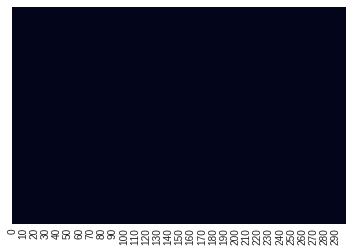

In [13]:
sns.heatmap(features.isnull(),yticklabels=False,cbar=False )

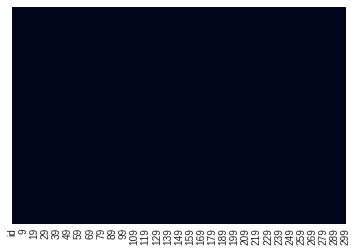

In [14]:
sns.heatmap(df_test.isnull(),yticklabels=False,cbar=False )

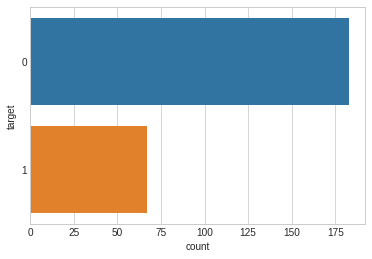

In [15]:
sns.countplot(y='target', data=df_train);

In [16]:
# Saving feature names for later use
feature_list = list(df_train.columns)
print(feature_list)

['id', 'target', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '

In [17]:
features_Scaled=pd.DataFrame(StandardScaler().fit_transform(features),columns=features.columns)
features_Scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.974717,-1.169956,-0.731456,0.535098,1.142759,0.540623,-0.423820,0.349920,-0.446382,-0.342796,...,0.201746,-0.331240,0.247523,-0.228612,0.439391,0.157961,0.328319,0.468780,1.054473,-0.971943
1,-0.737309,0.283037,1.682304,1.308350,1.821951,-0.074454,1.874460,-0.356719,0.675068,1.183966,...,-0.758492,-0.709799,-1.130922,2.382589,0.940068,-1.396604,0.436464,-0.017203,-1.999355,-0.450893
2,0.198240,1.456971,-0.851523,-1.012478,-0.006887,0.032999,-1.439569,0.210541,-0.649364,-0.024555,...,-1.290767,0.756641,-0.977653,1.417600,0.660921,-0.255700,-0.316787,-0.141573,-0.640454,0.706032
3,-0.896252,-0.962236,-1.483945,0.287014,0.563168,0.697171,1.106720,0.085783,-0.081911,-0.640217,...,-1.348283,1.037693,0.581395,-0.620340,-0.555008,-0.116542,-0.898886,-1.116673,0.892800,3.604844
4,0.914488,-1.584348,0.446442,-0.255336,-0.245293,-0.780311,0.323170,-0.650096,-0.685251,-0.502412,...,-0.186249,0.679209,-0.993273,1.135747,-0.502358,-0.385326,1.648624,1.520175,-0.373112,-0.775872


## Build Model

KNeighborsClassifier

In [18]:
test = df_test.drop(['id'],axis=1)
test_Scaled = pd.DataFrame(StandardScaler().fit_transform(test),columns=test.columns)

In [19]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(features_Scaled, labels)
y_pred = classifier.predict(test_Scaled)
y_pred.shape

(19750,)

In [20]:
submission = pd.DataFrame()
dataframe_Y=pd.DataFrame(y_pred, columns=['target']) 

submission=pd.concat([df_test['id'],dataframe_Y],axis=1)

submission.to_csv('./Submit.csv',index=False)

In [21]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.1, random_state = 42)

In [22]:
# What is base line for prediction accuracy?
target_count = df_train['target'].value_counts()
target_count[0]/(sum(target_count)) 

0.732

In [23]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [24]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)
errors
# Print out the mean absolute error (mae)
# print('Mean Absolute Error:', round(np.mean(errors), 2),)


array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0])

In [25]:
from sklearn.metrics import roc_auc_score,accuracy_score

# Calculate roc auc
roc_value_train = roc_auc_score(train_labels,  rf.predict_proba(train_features)[:, 1])
roc_value_test = roc_auc_score(test_labels, rf.predict_proba(test_features)[:, 1])
roc_value_train, roc_value_test

(1.0, 0.8600000000000001)

In [26]:
as_train = accuracy_score(train_labels, rf.predict(train_features))
as_test = accuracy_score(test_labels, rf.predict(test_features))
as_train, as_test

(1.0, 0.8)

In [27]:
df_test.shape

(19750, 301)

In [28]:
test_sub = df_test.drop(['id'], axis = 1)
result = predictions = rf.predict(test_sub)
result.shape

(19750,)

In [29]:
data = pd.DataFrame({
    'id' : np.array(df_test['id']),
    'target' : np.array(result)
})

In [30]:
submission = pd.DataFrame({
    'id' : df_test['id'],
    'target' : result
})
submission.to_csv('/kaggle/working/submission.csv', index=False)